# PyTorch를 통한 Object Detection

- yolo v3를 통한 object detection 적용
- 모델 구현은 하지 않음

https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98 참고
<https://github.com/cfotache/pytorch_objectdetecttrack.git> 다운 필요

## module, library import

In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size = 416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

C:\Users\user\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


- config 폴더의 파일의 경로를 변수명에 저장하고, hyper parameter를 설정한다.
- model 변수에 모델 구조와 가중치들을 넣는다.
<br>
<br>
- config_path : 각 레이어마다의 hyper parameter가 기록되어 있음
ex) batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky ...
- weights_path : 모델 가중치가 기록되어 있음. config 폴더의 download_weights.sh를 실행시켜 다운 받아야 함. sh 없을 경우 메모장으로 열어서 링크에서 직접다운 받는다.(250mb의 저장 공간 필요)
- class_path : 클래스가 기록되어 있음

## detect 함수 정의

In [3]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

- detect_image 함수 정의
- img_transforms 변수에 compose 함수를 이용하여 이미지가 들어왔을때 텐서 형태로 바꿔준다.
- with torch.no_grad(): 기록 추정에 대한 방지에 사용됨. 모델 평가에 사용된다.
- utils.non_max_suppression : 모르겠음
<br>
<br>
- imga_tensor.unsqueeze : Returns a new tensor with a dimension of size one inserted at the specified position.
<https://pytorch.org/docs/stable/torch.html>

## inference 실행

C:\Users\user\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Inference Time: 0:00:01.039221


<Figure size 432x288 with 0 Axes>

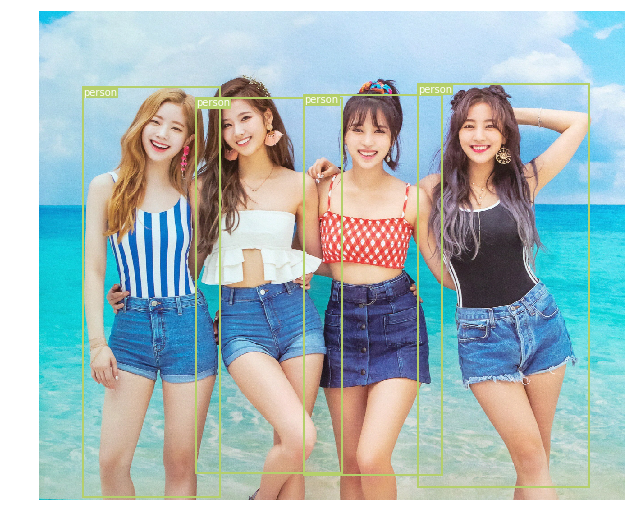

In [4]:
# load image and get detections
img_path = "images/twice.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time) # 경과시간 계산
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

- 이미지 불러와서 위에서 정의한 detect_image 함수를 사용하여 inference하는 내용.
- 중요하게 볼 내용은 결과 파일(?)이 어떤 형식으로 생성되었나가 중요하기에 아래와 같이 결과물 출력

In [5]:
detections

tensor([[111.2539,  96.0103, 214.6707, 362.4595,   0.9950,   0.9998,   0.0000],
        [ 30.8288,  88.2583, 128.2362, 379.3841,   0.9948,   0.9999,   0.0000],
        [268.8342,  86.3033, 390.0789, 372.3242,   0.9945,   0.9999,   0.0000],
        [188.1487,  93.7187, 286.0407, 364.0706,   0.9511,   0.9999,   0.0000]],
       device='cuda:0')

In [6]:
detections.shape

torch.Size([4, 7])

- 4행 7열의 행렬이 결과물로 출력된 것을 볼 수가 있으며, if 문을 참고했을 때  x1, y1, x2, y2, conf, cls_conf, cls_pred 순서대로 값이 입력된 것을 알 수 있다.(따라서 0은 사람을 나타냄)